In [2]:
# Data preparation for the ML-pipeline

import os
import subprocess
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import imutils
import pathlib
import shutil

In [10]:
# Tile the huge dataset at a certain zoom level (resolution per tile)
# Written down for the sake of completeness
# https://gdal.org/programs/gdal2tiles.html

SOURCE = "./smallarea.tif"
DESTINATION = "./smallareatiled"
GDAL2TILES = "C:/devtools/anaconda3/lib/site-packages/GDAL-3.0.2-py3.9-win-amd64.egg-info/scripts/gdal2tiles.py"
ZOOM = "10"
THREADS = "8"
NODATA_VAL = "0"

process = subprocess.run([
        "python", 
        GDAL2TILES,
        f"--zoom={ZOOM}",
        SOURCE,
        DESTINATION,
        "-x",
        f"--processes={THREADS}",
        f"-a {NODATA_VAL}"
    ], shell=True)

print(str(process.stdout)) 
print(str(process.stderr))


None
None


In [ ]:
# For greyscale (single-band) images ``gdal2tiles`` faces some problems as it expects the data in a different format
# https://gis.stackexchange.com/questions/200251/how-to-use-gdal2tiles-on-a-custom-tiff-image-recieved-from-providers-to-generate

stream = os.popen("python C:/devtools/anaconda3/lib/site-packages/GDAL-3.0.2-py3.9-win-amd64.egg-info/scripts/gdal_translate -of GTiff -ot byte ./atlamb_W_nDOM_50cm.tif ./atlambbytes_W_nDOM_50cm.tif -scale 0 518")
output = stream.read()
print(output)

In [12]:
# Copy the files into one directory accordingly (from previous structure of "[...]/<zoom-level>/<row-id>/<column-id>.jpg")
import ctypes

#                      actual     mask      merged
MODE: ctypes.c_uint8 = 0b1     #| 0b10    | 0b100

ZOOM_LVL = "20"
PATH_TO_MASK = "./tiled_mask/20"
PATH_TO_ACTUAL = "./tiled/20"

path_mask = pathlib.Path(PATH_TO_MASK)
path_actual = pathlib.Path(PATH_TO_ACTUAL)

destination_dataset = "./smallareatiled/fused20"

for p in path_actual.rglob("*"):
    p = p.as_posix()
    if p.endswith(".png") or p.endswith(".jpg"):
        tile_path = p[p.index(ZOOM_LVL)+3:]
        tile_name = tile_path.replace("/", "-")
        
        if (MODE & 0b1):
            shutil.copy(os.path.join(path_actual, tile_path), os.path.join(destination_dataset, tile_name))
        if (MODE & 0b10):
            shutil.copy(os.path.join(path_mask, tile_path), os.path.join(destination_dataset, tile_name))
        
        # For some cases it might be handy to have them side by side for comparisions
        if (MODE & 0b100):
            shutil.copy(os.path.join(path_actual, tile_path), os.path.join(destination_dataset + "merged", tile_name + "-actual.png"))
            shutil.copy(os.path.join(path_mask, tile_path), os.path.join(destination_dataset + "merged", tile_name + "-mask.png"))

In [ ]:
# Creating a binary mask from an rgb output
# Geodata preprocessing might export it as rgb images which is unfit for most (binary) ML-pipelines ...

masks_path = pathlib.Path("C:/Users/mathias/Documents/Sync/Master/sem3/P2/dataset/mask")
destination_dataset = "C:/Users/mathias/Documents/Sync/Master/sem3/P2/dataset/mask_bin"

for p in masks_path.rglob("*"):
    if p.name.endswith(".png"):
        tile_name = p.as_uri()[p.as_uri().rfind("/")+1:]
        
        img = Image.open(p.absolute()).convert("RGBA")
        img = np.array(img)

        # Get the alpha value of each pixel
        alphas = img[:, :, 3]

        # Find the indices where the alpha is bigger 0
        not_transparent_indices = np.where(alphas > 0)

        # Greyscale mask: 0 = black, 255 = white
        mask = np.zeros((img.shape[0], img.shape[1]), dtype="uint8")
        mask[not_transparent_indices] = 255

        cv2.imwrite(os.path.join(destination_dataset, tile_name), mask)

(1, 1020, 1, 2)


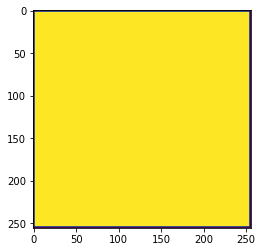

In [7]:
# Testing necessary steps for the ML pipeline
# Finding all features and their bounding boxes

image_path = "C:/boku/geodata/Wien/BaumKatAUTLAMB/tiled_exclusive/20/571710/684703.png"

img = Image.open(image_path).convert("RGBA")
img = np.array(img)

alphas = img[:, :, 3]

not_transparent_indices = np.where(alphas > 0)

mask = np.zeros((img.shape[0], img.shape[1]), dtype="uint8")
mask[not_transparent_indices] = 255

# find the contours in the mask
cnts = cv2.findContours(mask.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
cnts = imutils.grab_contours(cnts)
print(np.array(cnts).shape)

for i, c in enumerate(cnts):
    # draw the contour and show it
    cv2.drawContours(mask, [c], -1, 200, 2)
    
    maxs = np.amax(c, axis=0).reshape(2)
    mins = np.amin(c, axis=0).reshape(2)

    mask = cv2.rectangle(mask, mins, maxs, 200, 2)

    cv2.imshow("Image", mask)
    plt.imshow(mask)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [58]:
image_path = "C:/Users/mathias/Documents/Sync/Master/sem3/P2/dataset/actual/571448-684976.png"
mask_path = "C:/Users/mathias/Documents/Sync/Master/sem3/P2/dataset/mask_bin/571448-684976.png"

img = Image.open(image_path).convert("RGB")
mask = Image.open(mask_path)
mask = np.array(mask)

# find the contours in the mask (= individual features (small errors here))
cnts = cv2.findContours(mask.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
cnts = imutils.grab_contours(cnts)

boxes = []
# loop over the contours and define its bounding boxes
for c in cnts:
    maxs = np.amax(c, axis=0).reshape(2)
    mins = np.amin(c, axis=0).reshape(2)
    boxes.append([mins[0], mins[1], maxs[0], maxs[1]])

# Number of Bounding Boxes
obj_ids = np.array(list(range(len(boxes))))
# Split mask into seperate mask

mask = mask[None, :, :]
masks = np.array([x > 0 for x in (y for y in mask)])

print(masks.shape)

(1, 256, 256)
